Соревнование “Flight Delays”

Целью этого задания является участие в соревновании на платформе Kaggle, посвященном предсказанию задержек рейсов. Вам предстоит проанализировать предоставленные данные, построить модели машинного обучения и улучшить их с целью достижения точности предсказаний выше 0.7 (метрика AUC-ROC).

https://www.kaggle.com/competitions/flight-delays-fall-2018/overview

Этапы выполнения задания:
1.	Регистрация на Kaggle: Если у вас еще нет аккаунта, зарегистрируйтесь на платформе Kaggle.
2.	Изучение данных: Перейдите на страницу соревнования по ссылке, загрузите и изучите данные. Поймите структуру данных, какие признаки могут влиять на задержку рейсов.
3.	Предобработка данных: Проведите предобработку данных: очистите их от пропусков, выполните кодирование категориальных признаков, масштабирование данных и другие необходимые шаги.
4.	Построение модели: Разработайте несколько моделей машинного обучения, используя библиотеки Python (например, scikit-learn, XGBoost, CatBoost). Оцените качество каждой модели, используя перекрестную проверку и метрику AUC-ROC.
5.	Оптимизация модели: Настройте гиперпараметры модели с использованием методов GridSearchCV или RandomizedSearchCV, чтобы достичь лучших результатов.
6.	Сабмит предсказаний: Создайте файл с предсказаниями на тестовой выборке и загрузите его на платформу Kaggle. Ваша цель — достичь метрики AUC-ROC выше 0.7.
Документация: Оформите результаты вашего анализа, предобработки данных, построения и оптимизации модели в Jupyter Notebook. Подготовьте отчет с визуализациями и комментариями.

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import catboost as cb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [59]:
train_data = pd.read_csv('material_for_work/flight_delays_train.csv')
test_data = pd.read_csv('material_for_work/flight_delays_test.csv')
sample = pd.read_csv('material_for_work/sample_submission.csv')

# Объединяем данные из файлов train_data и test_data для предобработки категориальных данных
full_data = pd.concat((train_data, test_data))

In [48]:
# Просмотр информации о датасете
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              200000 non-null  object
 1   DayofMonth         200000 non-null  object
 2   DayOfWeek          200000 non-null  object
 3   DepTime            200000 non-null  int64 
 4   UniqueCarrier      200000 non-null  object
 5   Origin             200000 non-null  object
 6   Dest               200000 non-null  object
 7   Distance           200000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 15.3+ MB


In [49]:
full_data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


Features:

- Month (месяц), DayofMonth (день месяца), DayOfWeek (день недели)
- DepTime – departure time (время отправления)
- UniqueCarrier – code of a company-career (код компании-перевозчика)
- Origin – flight origin (пункт отправления рейса)
- Dest – flight destination (пункт назначения рейса)
- Distance – distance between Origin and Dest airports (расстояние между аэропортами)
- dep_delayed_15min – target (целевой признак)

In [50]:
# Исследовательская часть - графики распределения значений в признаках
# Создаём копию датасета для создания визуализаций
train_data_visual = train_data

# Функция, для создания графика
def plot_by_target(df, col, plot = sns.countplot, hue = 'dep_delayed_15min', sharey = False):
    g = sns.FacetGrid(train_data_visual, col = hue, height = 4.5, aspect = 1, sharey = sharey)
    g.map(plot, col)
    g.set_xticklabels(rotation = 90)

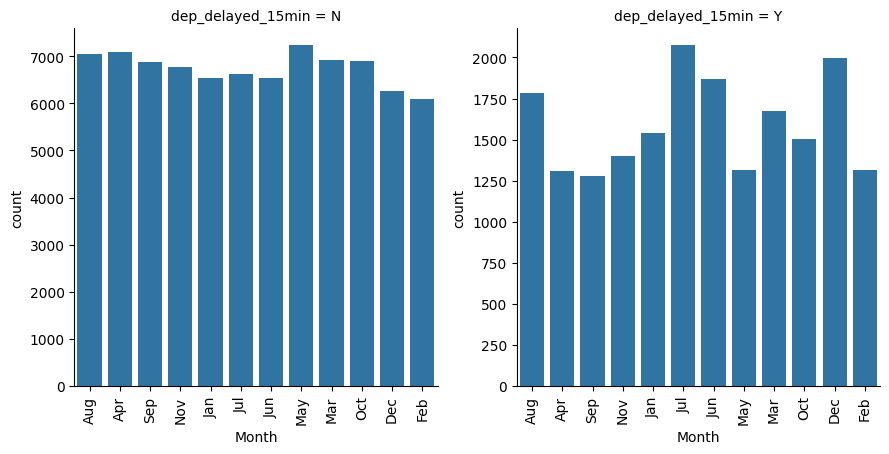

In [51]:
# Переименовываем названия месяцев, для лучшей наглядности.
# Выводим графики количества вылетов и задержек с распределением по месяцам
mon_map = {'c-1' : 'Jan', 'c-2' : 'Feb', 'c-3' : 'Mar', 'c-4' : 'Apr', 'c-5' : 'May', 'c-6' : 'Jun',
           'c-7' : 'Jul', 'c-8' : 'Aug', 'c-9' : 'Sep', 'c-10' : 'Oct', 'c-11' : 'Nov', 'c-12' : 'Dec'}
train_data_visual['Month'] = train_data_visual['Month'].map(mon_map)
# +
plot_by_target(train_data_visual, 'Month')

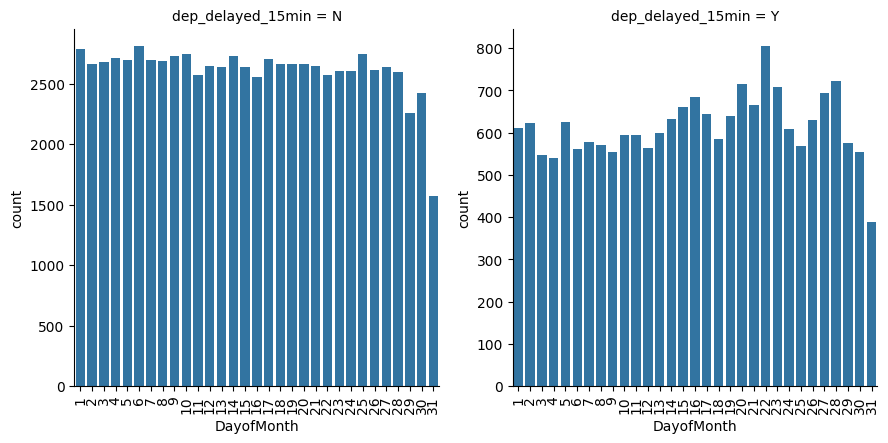

In [52]:
# Преобразуем дни месяца в числовые значения.
# Выводим графики количества вылетов и задержек с распределением по дням месяцов
train_data_visual.DayofMonth = train_data_visual.DayofMonth.str.slice(start = 2).astype(int)
# +
plot_by_target(train_data_visual, col = 'DayofMonth')

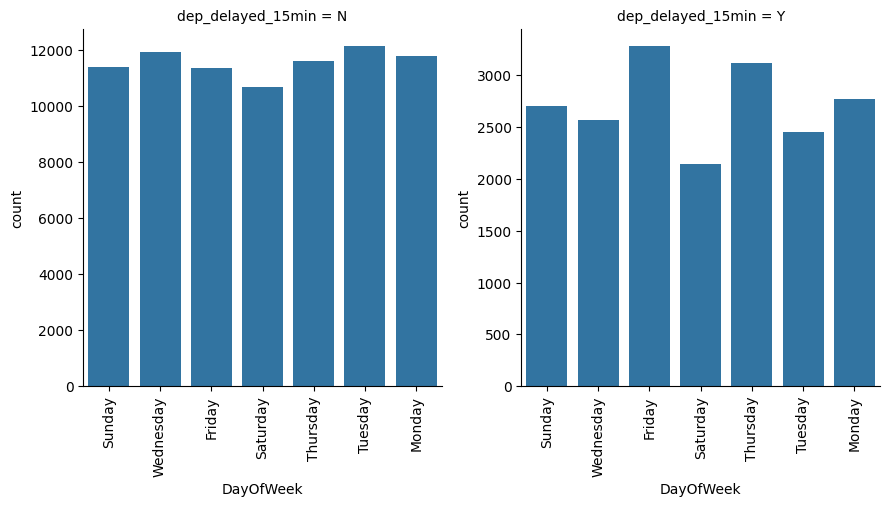

In [53]:
# Переименовываем названия дней недели, для лучшей наглядности.
# Выводим графики количества вылетов и задержек с распределением по дням недели
dayOfWeek = {'c-1' : 'Monday', 'c-2' : 'Tuesday', 'c-3' : 'Wednesday','c-4' : 'Thursday',
             'c-5' : 'Friday', 'c-6' : 'Saturday', 'c-7' : 'Sunday'}
train_data_visual['DayOfWeek'] = train_data_visual['DayOfWeek'].map(dayOfWeek)
# +
plot_by_target(train_data_visual, 'DayOfWeek')

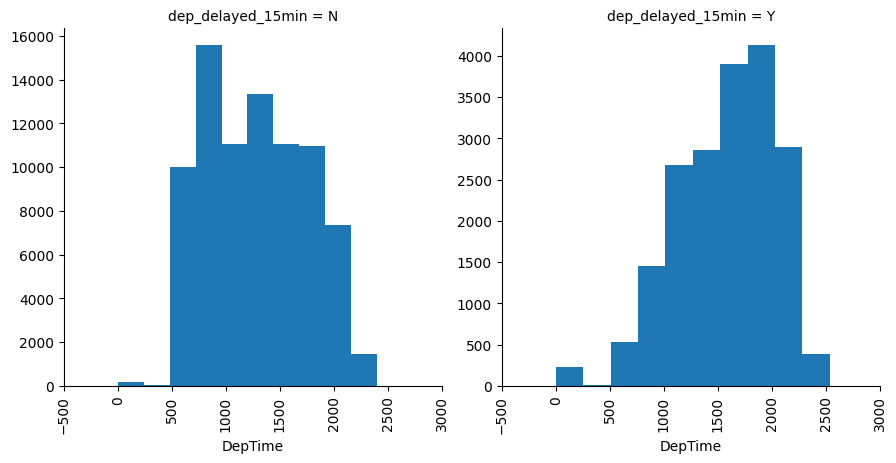

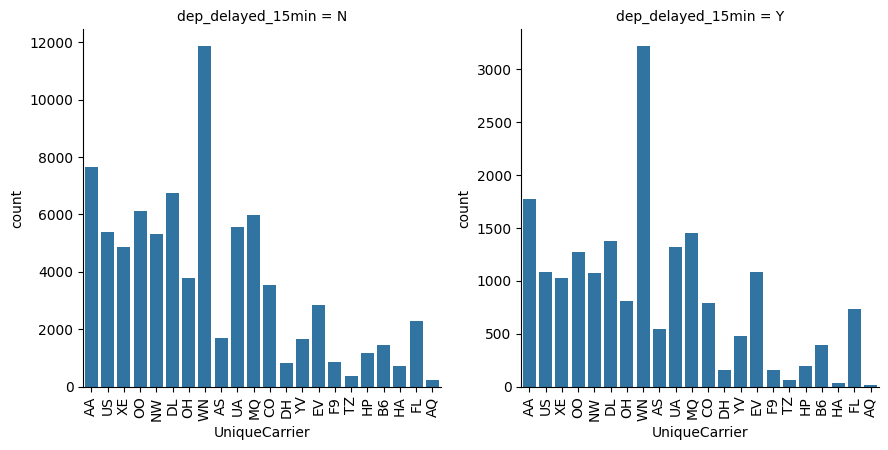

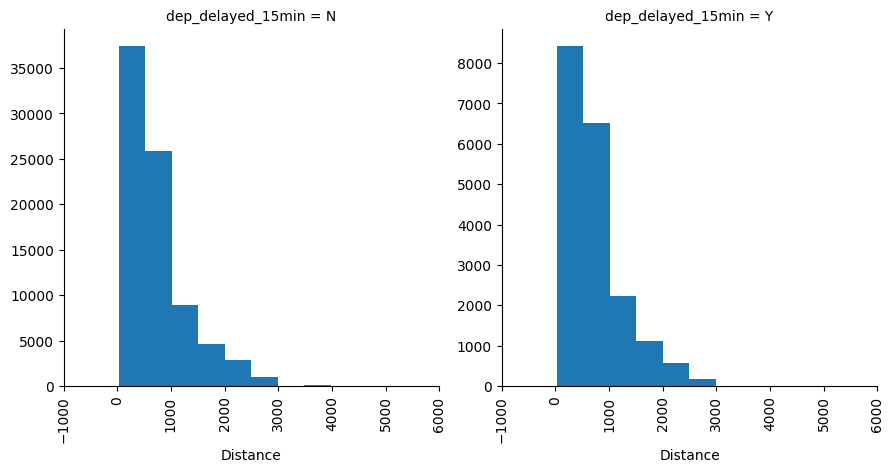

In [54]:
# Выводим графики количества вылетов и задержек с распределением по:
# - времени вылета рейса
plot_by_target(train_data_visual, col = 'DepTime', plot = plt.hist)
# - компаниям-перевозчикам
plot_by_target(train_data_visual, col = 'UniqueCarrier')
# - дальности перелёта
plot_by_target(train_data_visual, col = 'Distance', plot = plt.hist)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



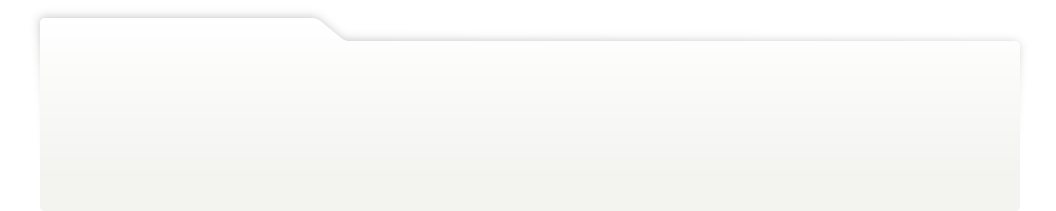
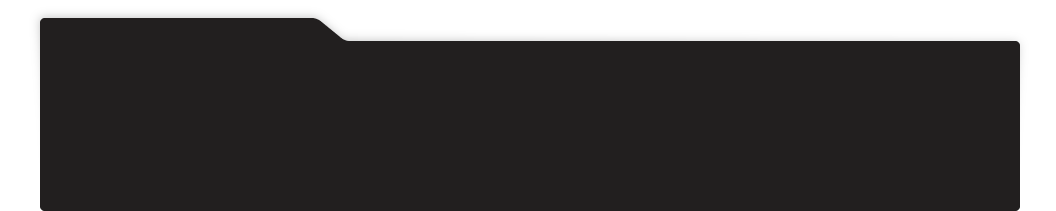
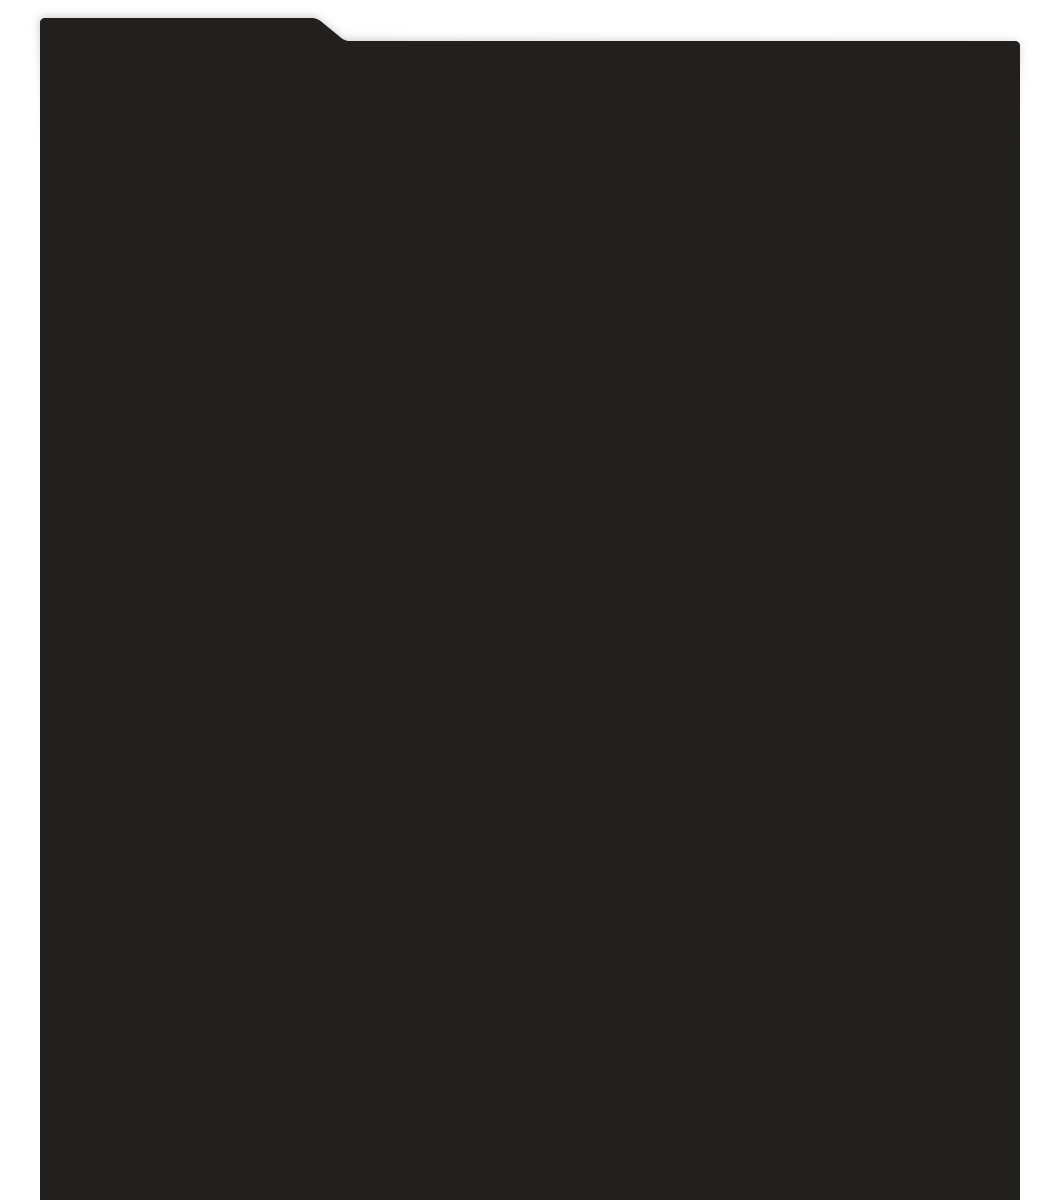
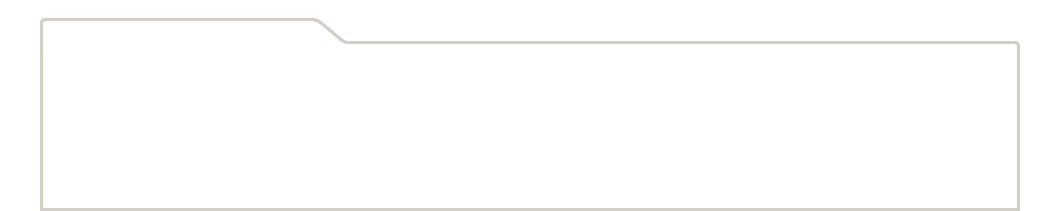
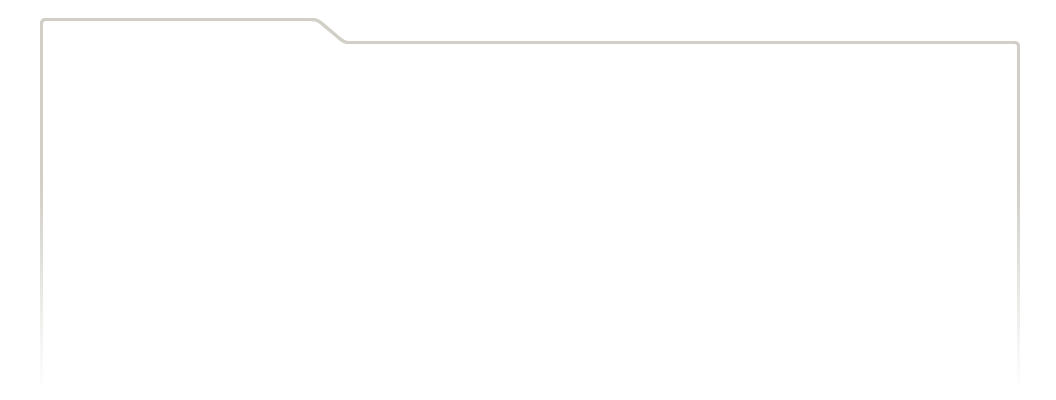
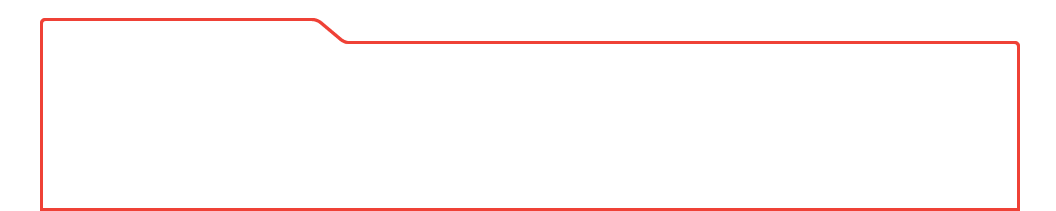
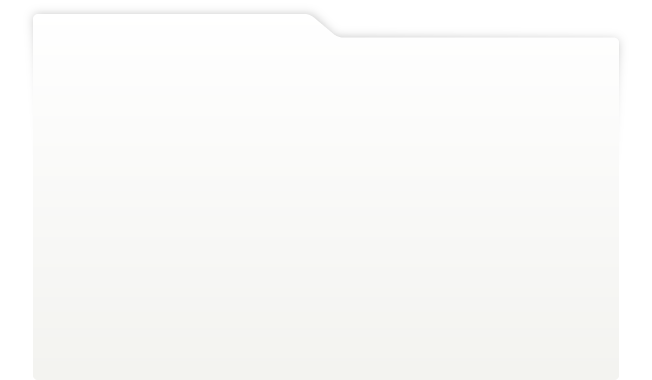
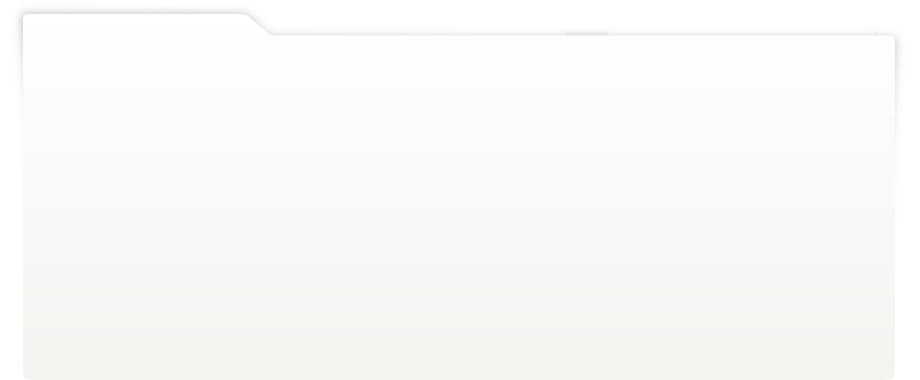
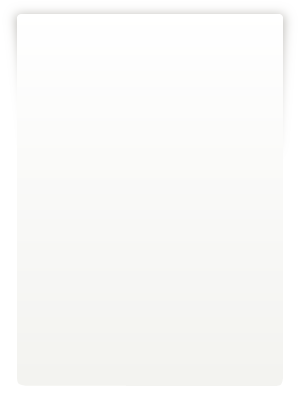
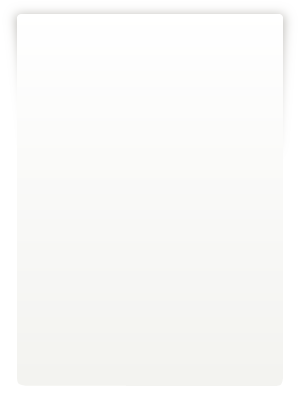
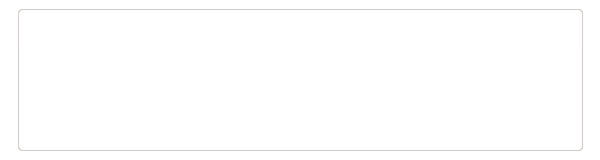
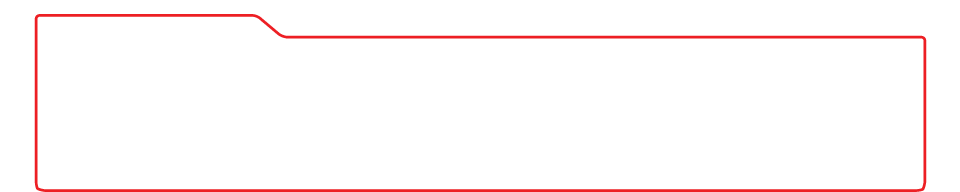
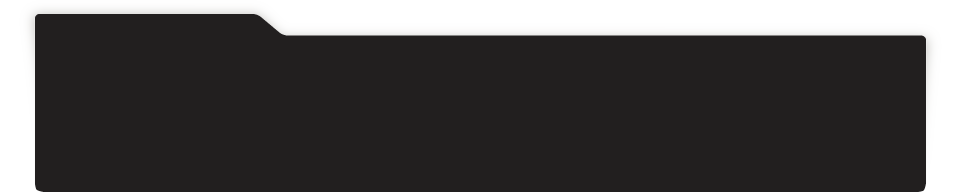
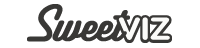
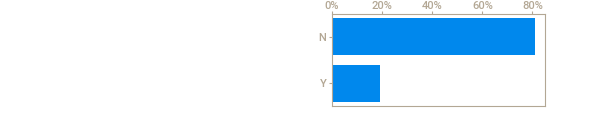
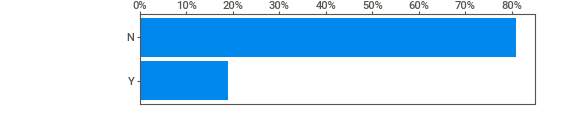
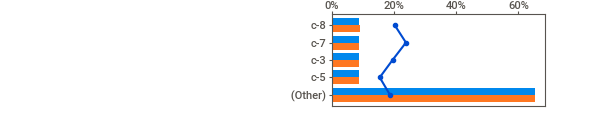
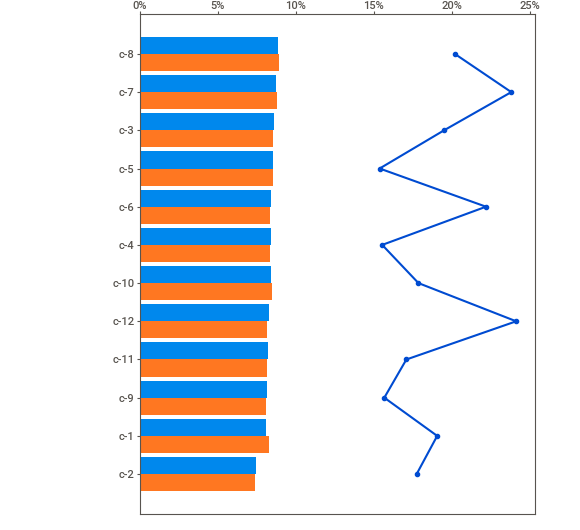
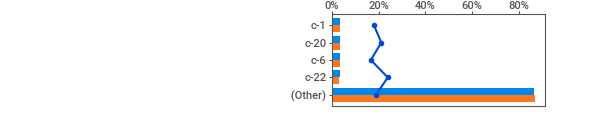
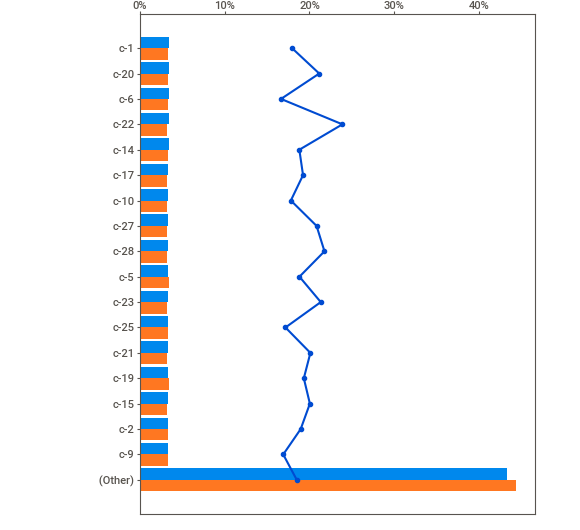
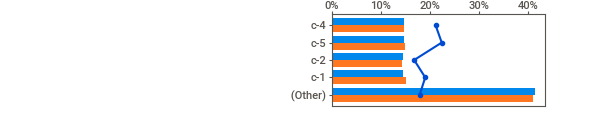
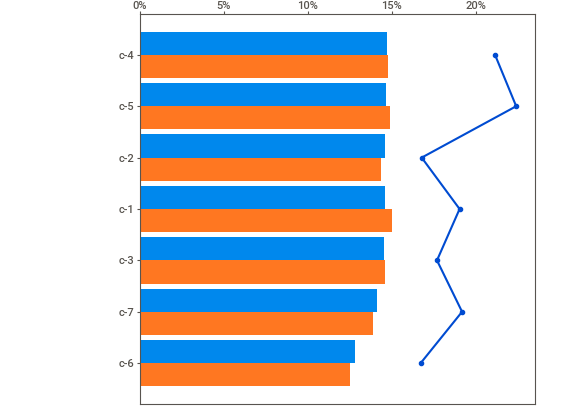
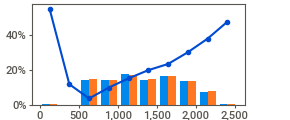
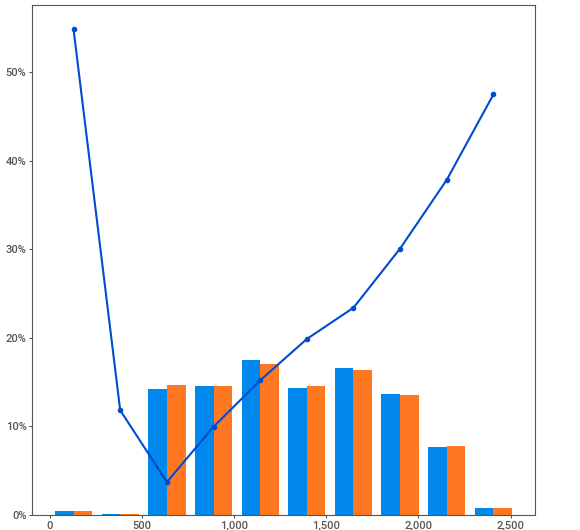
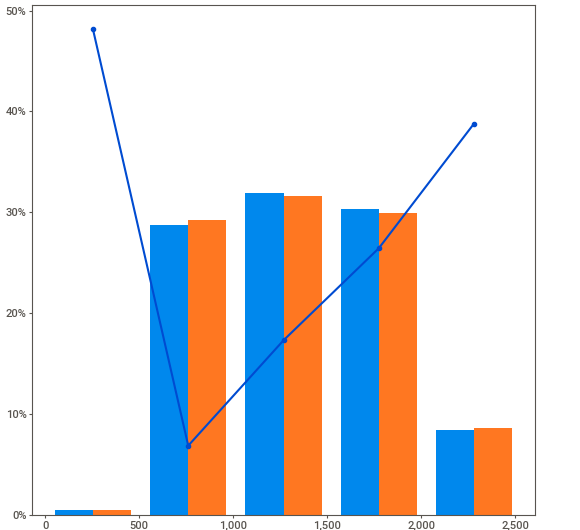
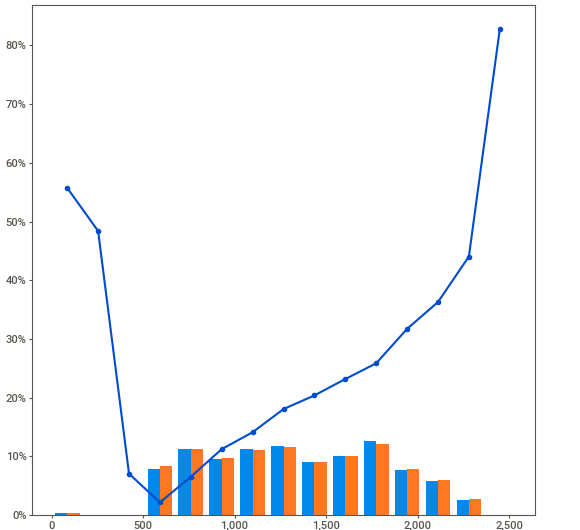
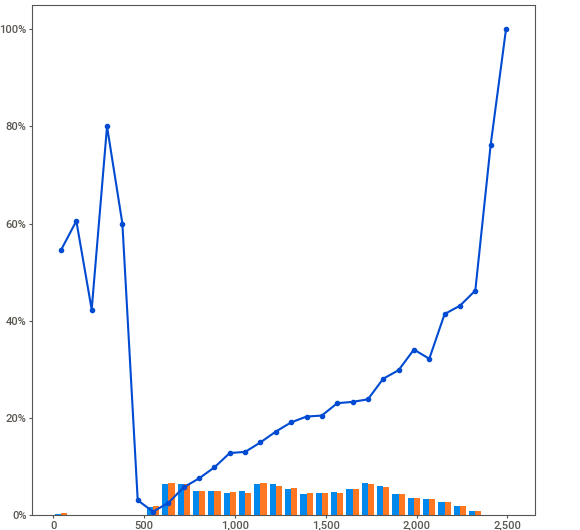
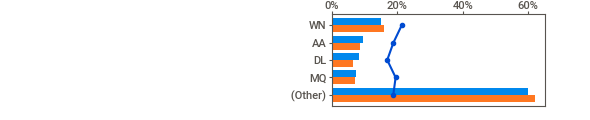
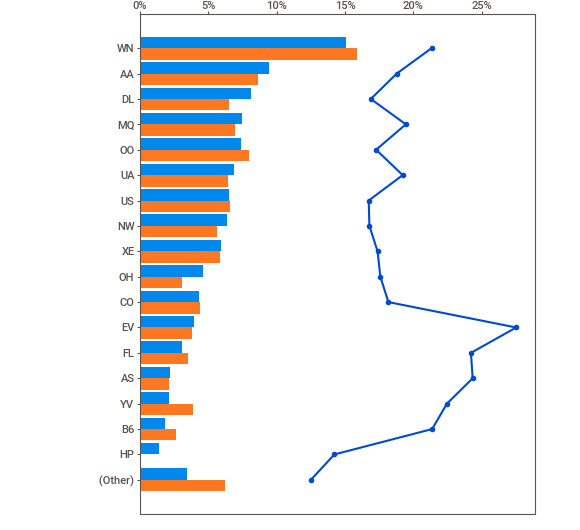
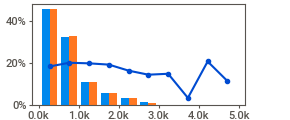
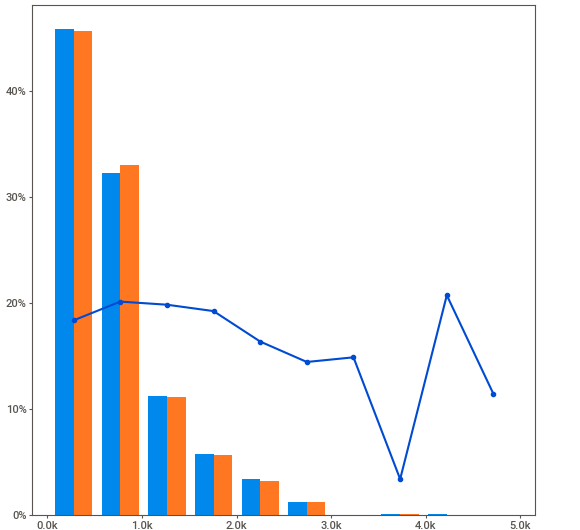
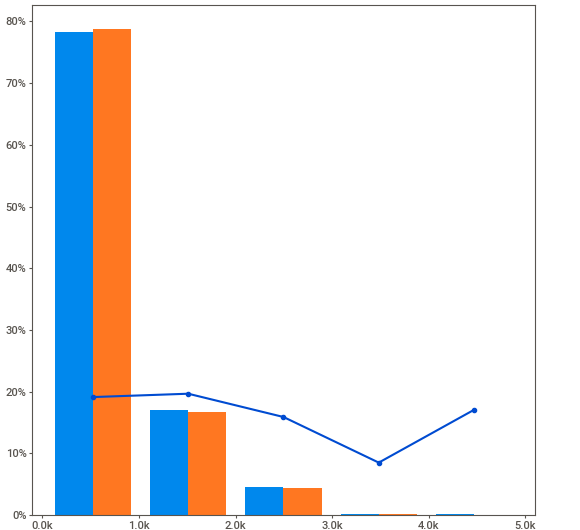
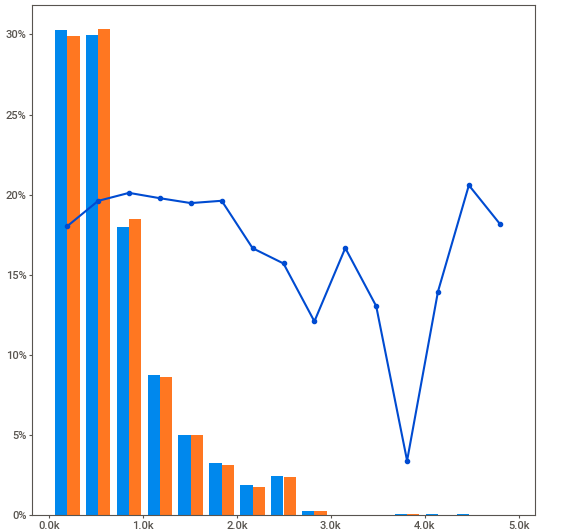
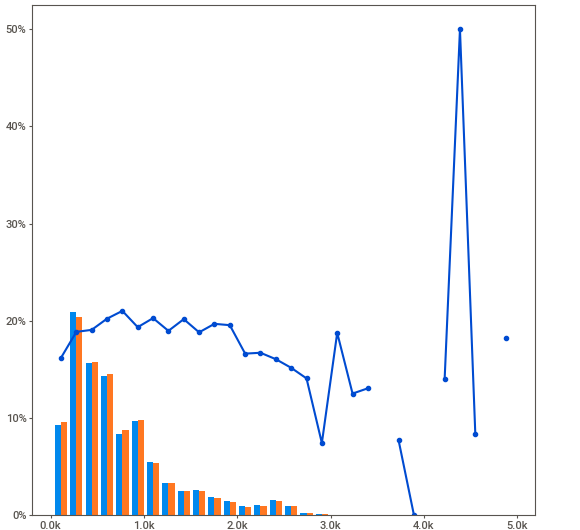
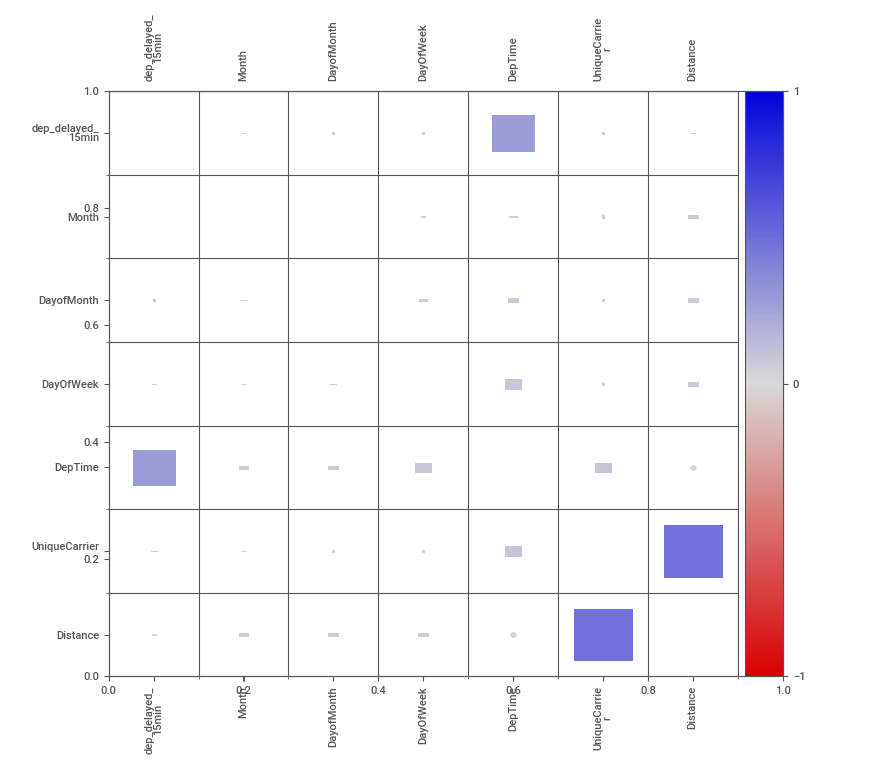
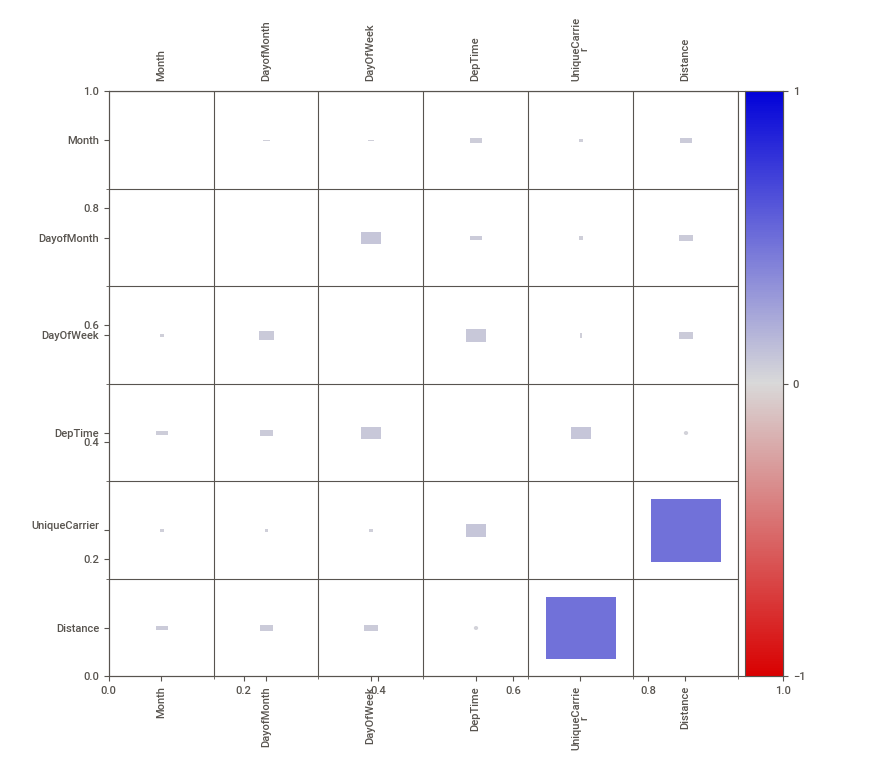

In [63]:
# Оригинальный способ проанализировать данные в датасете, с помощью библиотеки SWEETVIZ

# !pip install sweetviz
import sweetviz as sv

# Сравним данные из файлов train и test, с указанием целевой переменной
comparison_report = sv.compare([train_data, 'Train'], [test_data, 'Test'], target_feat = 'dep_delayed_15min')
comparison_report.show_notebook(layout = 'vertical', w = 1000, h = 750, scale = 1)

In [6]:
# Создаём новые признаки

# Добавление признака сезонности
full_data['Season'] = ''
full_data.loc[(full_data.Month == 'c-12') | (full_data.Month == 'c-1') | (full_data.Month == 'c-2'), 'Season'] = 'winter'
full_data.loc[(full_data.Month == 'c-3') | (full_data.Month == 'c-4') | (full_data.Month == 'c-5'), 'Season'] = 'spring'
full_data.loc[(full_data.Month == 'c-6') | (full_data.Month == 'c-7') | (full_data.Month == 'c-8'), 'Season'] = 'summer'
full_data.loc[(full_data.Month == 'c-9') | (full_data.Month == 'c-10') | (full_data.Month == 'c-11'), 'Season'] = 'autumn'

# Добавление признака времени суток
full_data['DepTime_of_day'] = ''
full_data.loc[(full_data.DepTime > 0) & (full_data.DepTime <= 200), 'DepTime_of_day'] = 'midnight'
full_data.loc[(full_data.DepTime > 200) & (full_data.DepTime <= 600), 'DepTime_of_day'] = 'early_morning'
full_data.loc[(full_data.DepTime > 600) & (full_data.DepTime <= 1000), 'DepTime_of_day'] = 'morning'
full_data.loc[(full_data.DepTime > 1000) & (full_data.DepTime <= 1400), 'DepTime_of_day'] = 'midday'
full_data.loc[(full_data.DepTime > 1400) & (full_data.DepTime <= 1800), 'DepTime_of_day'] = 'afternoon'
full_data.loc[(full_data.DepTime > 1800) & (full_data.DepTime <= 2200), 'DepTime_of_day'] = 'evening'
full_data.loc[(full_data.DepTime > 2200) & (full_data.DepTime <= 2400), 'DepTime_of_day'] = 'midnight'

# Добавление двух новых признаков с часами и минутами, на основе признака с временем отправления
full_data['hour'] = full_data['DepTime'] // 100
full_data.loc[full_data['hour'] == 24, 'hour'] = 0
full_data.loc[full_data['hour'] == 25, 'hour'] = 1
full_data['minute'] = full_data['DepTime'] % 100

# Добавление признака с маршрутом следования "город вылета - город посадки"
full_data['FromTo'] = full_data['Origin'] + '-->' + full_data['Dest']

# Добавление признака, показывающего выходной день или нет
full_data['is_weekend'] = (full_data['DayOfWeek'] == 'c-6') | (full_data['DayOfWeek'] == 'c-7')

# Результат CatBoost на ПК: ROC AUC - 0.7910 (без удаления исходных столбцов, с удалением результат становится хуже)

In [7]:
# Исследовательские признаки, ухудшившие результаты работы моделей, поэтому остались закомментироваными

# Distance - добавление признака дальности перелёта
# full_data['Distance_class'] = ''
# full_data.loc[full_data.Distance <= 500 , 'Distance_class'] = 'vshort'
# full_data.loc[(full_data.Distance > 500) & (full_data.Distance <= 1000), 'Distance_class'] = 'short'
# full_data.loc[(full_data.Distance > 1000) & (full_data.Distance <= 1500), 'Distance_class'] = 'mid'
# full_data.loc[(full_data.Distance > 1500) & (full_data.Distance <= 2000), 'Distance_class'] = 'midlong'
# full_data.loc[(full_data.Distance > 2000) & (full_data.Distance <= 2500), 'Distance_class'] = 'long'
# full_data.loc[full_data.Distance > 2500, 'Distance_class'] = 'vlong'

# Признак, объединяющий компанию-перевозчика и город отправления
# full_data['UC_Origin'] = full_data['UniqueCarrier'] + '-->' + full_data['Origin']

# Признак, объединяющий город отправления и время суток
# full_data['Origin_DepTime_of_day'] = full_data['Origin'] + '-->' + full_data['DepTime_of_day']

# # Удаляем столбцы, на основании которых создавали новые признаки
# full_data = full_data.drop(['Month', 'DepTime', 'Origin', 'Dest'], axis = 1)

In [8]:
# Получаем датасет с новыми признаками
full_data.head(10)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Season,DepTime_of_day,hour,minute,FromTo,is_weekend
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N,summer,evening,19,34,ATL-->DFW,True
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N,spring,afternoon,15,48,PIT-->MCO,False
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N,autumn,afternoon,14,22,RDU-->CLE,False
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N,autumn,midday,10,15,DEN-->MEM,True
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y,autumn,evening,18,28,MDW-->OMA,True
5,c-8,c-3,c-4,1918,NW,MEM,MCO,683,N,summer,evening,19,18,MEM-->MCO,False
6,c-1,c-27,c-4,754,DL,PBI,LGA,1035,N,winter,morning,7,54,PBI-->LGA,False
7,c-4,c-29,c-6,635,OH,MSP,CVG,596,N,spring,morning,6,35,MSP-->CVG,True
8,c-7,c-28,c-5,735,AA,ONT,DFW,1189,N,summer,morning,7,35,ONT-->DFW,False
9,c-6,c-20,c-2,2029,OO,DEN,PSC,853,N,summer,evening,20,29,DEN-->PSC,False


In [9]:
# Разбиваем файл обратно на train и test
train_df = full_data[0:100000]
test_df = full_data[100000:]

In [10]:
# Подготовка данных для модели CatBoost, которая работает с категориальными признаками напрямую

# Копирование данных
train_df_cat = train_df.copy()
test_df_cat = test_df.copy()

# Определяем номера категориальных признаков
categ_feat_idx = np.where(train_df_cat.drop('dep_delayed_15min', axis = 1).dtypes == 'object')[0]
categ_feat_idx

# Выделяем отложенную выборку и переводим данные в столбце "dep_delayed_15min" в числа
X_train_cat = train_df_cat.drop('dep_delayed_15min', axis = 1).values
y_train_cat = train_df_cat['dep_delayed_15min'].map({'Y' : 1, 'N' : 0}).values
X_test_cat = test_df_cat.values

# Разделяем исходный набор данных на обучающую и тестовую выборки
X_train_part_cat, X_valid_cat, y_train_part_cat, y_valid_cat = train_test_split(X_train_cat,
                                                                                y_train_cat,
                                                                                test_size = 0.15,
                                                                                random_state = 42)

In [11]:
# Подготовка данных для модели XGBoost

# Копирование данных
train_df_xgb = train_df.copy()
test_df_xgb = test_df.copy()

# Преобразование категориальных признаков в числовые
le = LabelEncoder()
for col_name in train_df_xgb.columns:
    if train_df_xgb[col_name].dtypes == 'object':
        train_df_xgb[col_name]=le.fit_transform(train_df_xgb[col_name])

# Выделяем отложенную выборку
X_train_xgb = train_df_xgb.drop('dep_delayed_15min', axis = 1).values
y_train_xgb = train_df_xgb['dep_delayed_15min'].values
X_test_xgb = test_df_xgb.values

# Разделяем исходный набор данных на обучающую и тестовую выборки
X_train_part_xgb, X_valid_xgb, y_train_part_xgb, y_valid_xgb = train_test_split(X_train_xgb,
                                                                                y_train_xgb,
                                                                                test_size = 0.15,
                                                                                random_state = 42)

In [12]:
# Строим модели
models = {
    'XGBoost': xgb.XGBClassifier(),
    'CatBoost': cb.CatBoostClassifier(verbose = 0)
}

In [13]:
# Обучение моделей и вывод метрик
metrics = []

for model_name, model in models.items():
    if model_name == 'CatBoost':
        cat_features = categ_feat_idx
        model.fit(X_train_part_cat, y_train_part_cat, cat_features = categ_feat_idx)
        y_pred = model.predict(X_valid_cat)
        y_pred_proba_cat = model.predict_proba(X_valid_cat)[:, 1]
        roc_auc = roc_auc_score(y_valid_cat, y_pred_proba_cat)
    else:
        model.fit(X_train_part_xgb, y_train_part_xgb)
        y_pred = model.predict(X_valid_xgb)
        y_pred_proba_xgb = model.predict_proba(X_valid_xgb)[:, 1]
        roc_auc = roc_auc_score(y_valid_xgb, y_pred_proba_xgb)

    metrics.append({
        'Model': model_name,
        'ROC AUC': roc_auc
    })

metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,ROC AUC
0,XGBoost,0.744554
1,CatBoost,0.791067


In [14]:
# Определение лучшей модели по ROC AUC
best_model_name = metrics_df.sort_values(by = 'ROC AUC', ascending = False).iloc[0]['Model']
best_model_name

'CatBoost'

In [15]:
# Подбор гиперпараметров
param_grid = {
    'CatBoost': {
        'depth': [5, 8, 10],
        'iterations': [800, 1000, 1200],
        'learning_rate': [0.09, 0.13, 0.16]
    },
    'XGBoost': {
        'max_depth': [3, 5],
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1]
    }
}

best_model = models[best_model_name]
grid_search = GridSearchCV(estimator = best_model,
                           param_grid = param_grid[best_model_name],
                           cv = 3,
                           scoring = 'roc_auc',
                           verbose = 1)

if best_model_name == 'CatBoost':
    grid_search.fit(X_train_part_cat, y_train_part_cat, cat_features = categ_feat_idx)
else:
    grid_search.fit(X_train_part_xgb, y_train_part_xgb)

best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'depth': 5, 'iterations': 1000, 'learning_rate': 0.16}


In [23]:
# Создаём финальную модель, обучаем и получает результаты

final_model = cb.CatBoostClassifier(iterations = 1000,  # 1000
                                    learning_rate = 0.16,  # 0.13
                                    depth = 5,  # 8
                                    random_seed = 42,
                                    verbose = 0)

final_model.fit(X_train_part_cat, y_train_part_cat, cat_features = categ_feat_idx)

y_train_preds = final_model.predict(X_train_part_cat)

metrics = []
y_pred_proba = final_model.predict_proba(X_valid_cat)[:, 1]

roc_auc = roc_auc_score(y_valid_cat, y_pred_proba)
print(f'ROC AUC: {roc_auc}')  # 0.7938

ROC AUC: 0.7924670653643857


In [24]:
# Обучаем на всей выборке
final_model.fit(X_train_cat, y_train_cat, cat_features = categ_feat_idx)

In [25]:
# Создаём лист с названиями категорий, удалив из него категорию 'dep_delayed_15min'
feature_columns = list(test_df_cat.columns)
feature_columns.remove('dep_delayed_15min')
feature_columns

['Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'UniqueCarrier',
 'Origin',
 'Dest',
 'Distance',
 'Season',
 'DepTime_of_day',
 'hour',
 'minute',
 'FromTo',
 'is_weekend']

In [26]:
# Получаем предикты
ctb_test_pred = final_model.predict_proba(test_df_cat[feature_columns])[:, 1]

In [27]:
# Сохраняем результаты в файл для загрузки на странице соревнования
sample_sub = pd.read_csv('sample_submission.csv', index_col = 'id')
sample_sub['dep_delayed_15min'] = ctb_test_pred
sample_sub.to_csv('ctb_pred_flightdelay.csv')

# Score kaggle.com: 0.74148